In [3]:
#%%

import numpy as np
import matplotlib.pyplot as plt
import os

main_dir = os.getcwd()
if not os.path.exists(os.path.join(main_dir, 'outputs')):
    os.makedirs(os.path.join(main_dir, 'outputs'))
out_dir = os.path.join(main_dir, 'outputs')

G = 6.67430e-11  # Gravitational constant [m^3 kg^-1 s^-2]
ms2mGal = 1.0e5 # Conversion factor from SI units to mGal (m/s^2 => mGal)

In [4]:
#%%

def airy_isostasy(rho_c, rho_w, rho_m, H):
    """
    Compute the thickness t of the crust above the seafloor
    by equating pressures at the base of the crust (Airy model):

        ==> t = H * (rho_c - rho_m) / (rho_w - rho_m)

    Parameters
    ----------
    rho_c : float
        Crust density [kg/m^3]
    rho_w : float
        Seawater density [kg/m^3]
    rho_m : float
        Mantle density [kg/m^3]
    H    : float
        Total crust thickness [m]

    Returns
    -------
    t : float
        Thickness of crust replaced by seawater [m]
    """
    
    t = H * (rho_c - rho_m) / (rho_w - rho_m)
    return t


def thin_sheet_anomaly(x, delta_rho, h, z0):
    """
    Compute gravity anomaly of a semi-infinite horizontal slab
    (Lowrie eqn. 2.101) of thickness h, density contrast delta_rho,
    at mid-depth z0, for horizontal coordinate(s) x.
    
       Δg = 2 * G * delta_rho * h * [ π/2 + arctan(x / z0) ]
    
    The result is in SI units of m/s^2, so we multiply by 1e5
    to convert to mGal.

    Parameters
    ----------
    x         : float or ndarray
        Horizontal distance from the 'edge' (x=0) [m]
    delta_rho : float
        Density contrast [kg/m^3]
    h         : float
        Thickness of slab [m]
    z0        : float
        Mid-depth of the slab [m]

    Returns
    -------
    dg : float or ndarray
        Gravity anomaly contribution in mGal.
    """
    
    delta_g = (2.0 * G * delta_rho * h) * ( np.pi/2.0 + np.arctan(x / z0) ) * ms2mGal

    return delta_g


def total_anomaly(x, rho_c, rho_w, rho_m, H):
    """
    Sum of 'above' thin sheet + 'below' thin sheet, following the
    logic in Lowrie §2.6.3.5

    Steps:
      1) Compute t from Airy isostasy
      2) "Above" slab: 
         thickness = t
         density contrast = (rho_c - rho_w)
         mid-depth = t/2
      3) "Below" slab:
         thickness = (H - t)
         density contrast = (rho_c - rho_m)
         mid-depth = z0_below = (H + t)/2  
      4) Sum results

    Parameters
    ----------
    x      : float or ndarray (horizontal distance, m)
    rho_c  : float (crust density, kg/m^3)
    rho_w  : float (water density, kg/m^3)
    rho_m  : float (mantle density, kg/m^3)
    H      : float (total crust thickness, m)

    Returns
    -------
    dg_net : float or ndarray
        Net gravity anomaly in mGal (sum of above+below).
    """
    
    # 1) thickness above the seafloor:
    t = airy_isostasy(rho_c, rho_w, rho_m, H)
    
    # 2) "above" slab
    h_above     = t
    dcontrast_a = rho_c - rho_w
    z0_above    = t / 2.0
    
    # 3) "below" slab
    h_below     = H - t
    dcontrast_b = rho_c - rho_m
    z0_below    = (H + t) / 2.0 
    
    # compute each contribution
    dg_above  = thin_sheet_anomaly(x, dcontrast_a, h_above,  z0_above)
    dg_below  = thin_sheet_anomaly(x, dcontrast_b, h_below,  z0_below)
    
    # 4) sum
    
    dg_net = dg_above + dg_below
    
    return dg_net

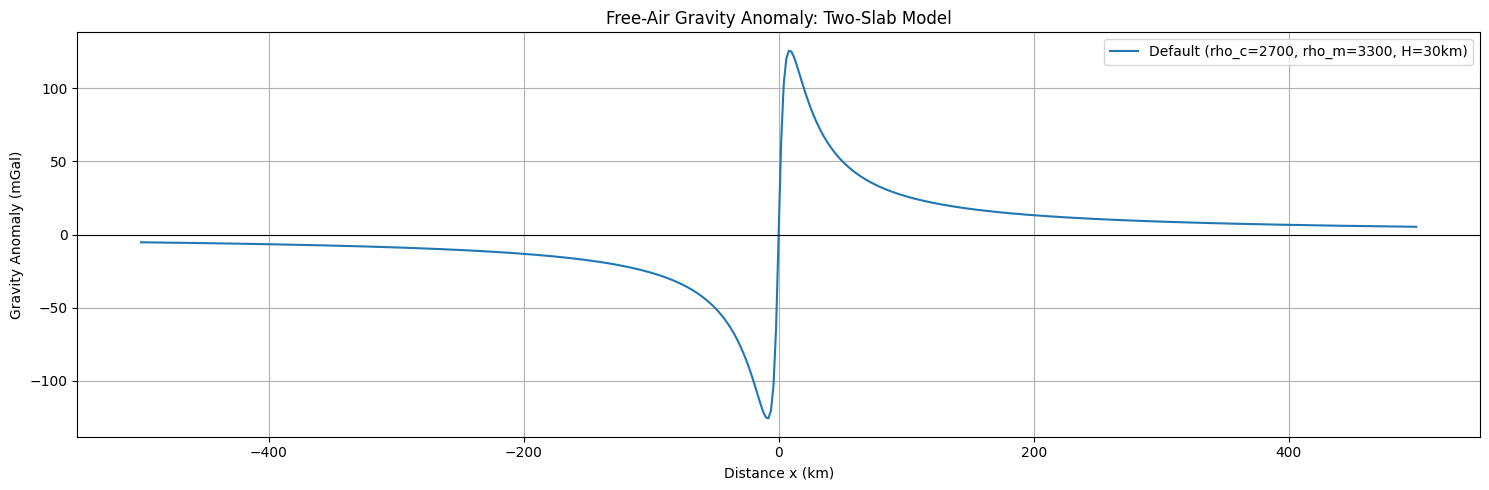

In [5]:
#%%

# Make an x-array from -500 km to +500 km, in meters
x_km = np.linspace(-500, 500, 501)  # 501 points
x_m  = x_km * 1.0e3

# Default parameters from fig 2
H_default = 30.0e3   # 30 km
rho_c_default = 2700.0
rho_w_default = 1030.0
rho_m_default = 3300.0

# Compute net anomaly with default parameters
dg_fig2 = total_anomaly(x_m, rho_c_default, rho_w_default, rho_m_default, H_default)

# Plot the result
plt.figure(figsize=(15,5))
plt.plot(x_km, dg_fig2, label="Default (rho_c=2700, rho_m=3300, H=30km)")
plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel("Distance x (km)")
plt.ylabel("Gravity Anomaly (mGal)")
plt.title("Free-Air Gravity Anomaly: Two-Slab Model")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'dg_fig2.png'))
plt.show()

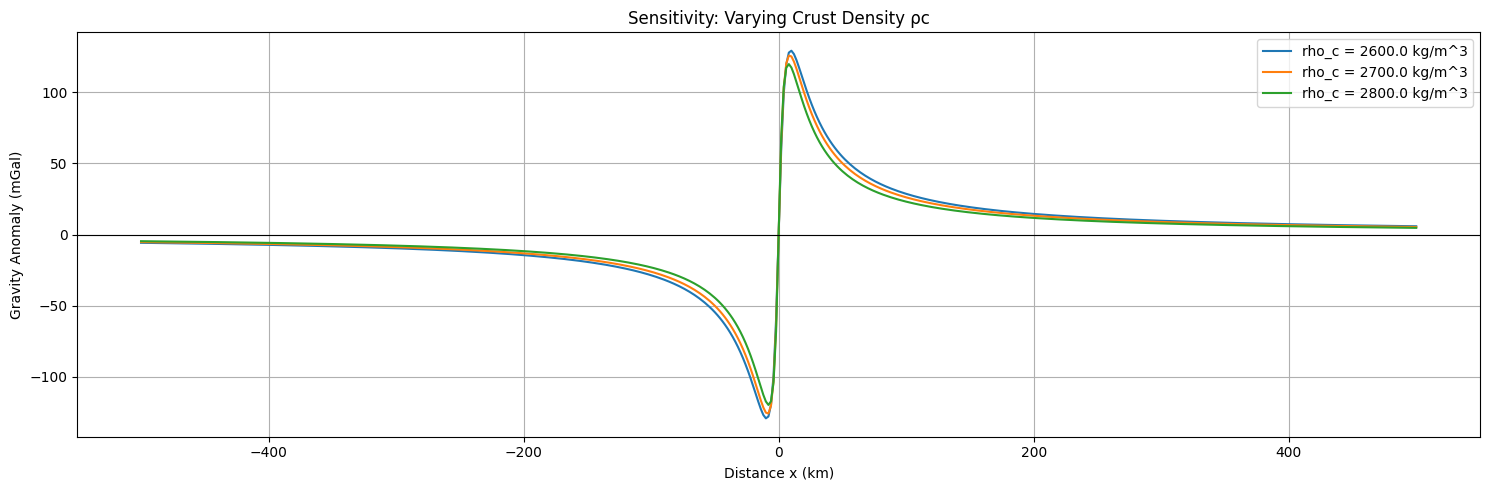

In [6]:
#%%

# -----------------------------------------------------------
# (d): Vary rho_c in {2600, 2700, 2800}
# -----------------------------------------------------------
rho_c_values = [2600.0, 2700.0, 2800.0]

plt.figure(figsize=(15,5))
for rc in rho_c_values:
    dg = total_anomaly(x_m, rc, rho_w_default, rho_m_default, H_default)
    plt.plot(x_km, dg, label=f"rho_c = {rc} kg/m^3")

plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel("Distance x (km)")
plt.ylabel("Gravity Anomaly (mGal)")
plt.title("Sensitivity: Varying Crust Density ρc")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'dg_vary_rho_c.png'))
plt.show()

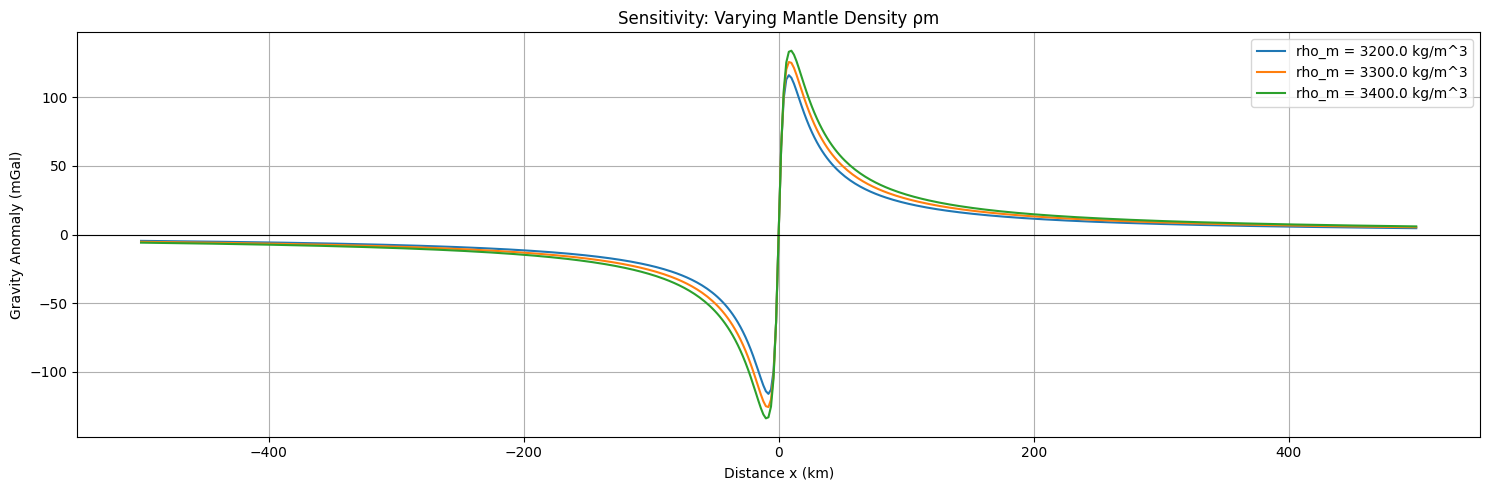

In [7]:
#%%

# -----------------------------------------------------------
# (e): Vary rho_m in {3200, 3300, 3400}
# -----------------------------------------------------------
rho_m_values = [3200.0, 3300.0, 3400.0]

plt.figure(figsize=(15,5))
for rm in rho_m_values:
    dg = total_anomaly(x_m, rho_c_default, rho_w_default, rm, H_default)
    plt.plot(x_km, dg, label=f"rho_m = {rm} kg/m^3")

plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel("Distance x (km)")
plt.ylabel("Gravity Anomaly (mGal)")
plt.title("Sensitivity: Varying Mantle Density ρm")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'dg_vary_rho_m.png'))
plt.show()

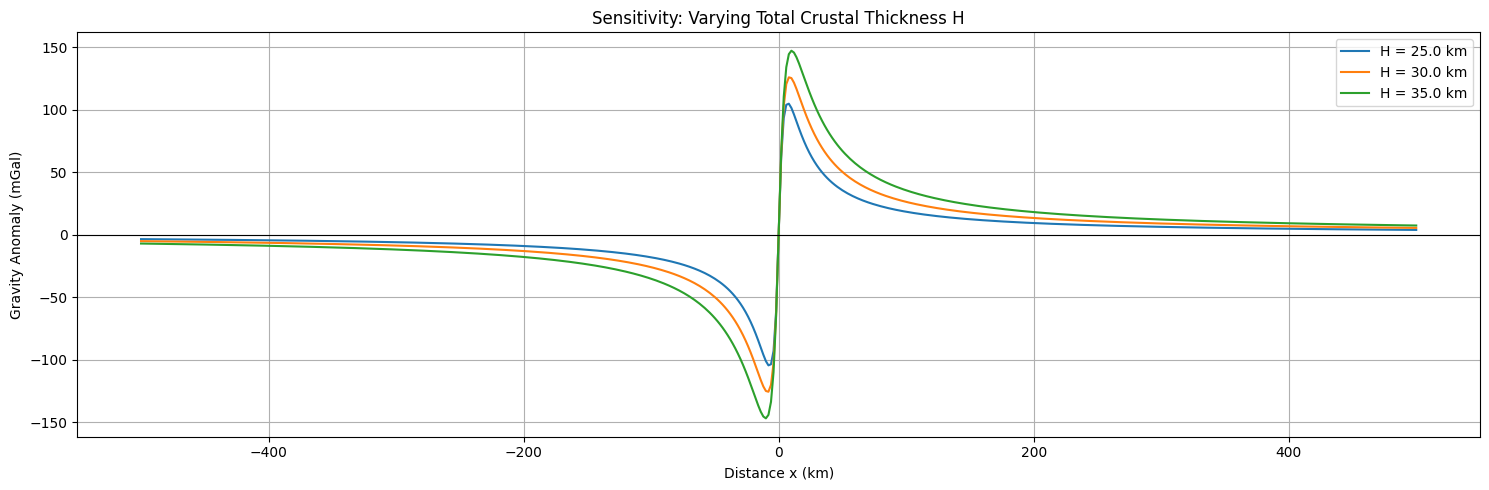

In [8]:
#%%

# -----------------------------------------------------------
# (f): Vary H in {25, 30, 35} km
# -----------------------------------------------------------
H_values = [25.0e3, 30.0e3, 35.0e3] # in meters

plt.figure(figsize=(15,5))
for HH in H_values:
    dg = total_anomaly(x_m, rho_c_default, rho_w_default, rho_m_default, HH)
    plt.plot(x_km, dg, label=f"H = {HH/1e3} km")

plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel("Distance x (km)")
plt.ylabel("Gravity Anomaly (mGal)")
plt.title("Sensitivity: Varying Total Crustal Thickness H")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'dg_vary_H.png'))
plt.show()